# ProfHMM Notebook Tutorial 2023:  PART 1 / ProfHMM training

In [1]:
import yaml as yml
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from submapp import *
from tools.tools_som import *
from submapp.tools.data_processing import *
from tools.preprocessing.preprocessor import normalization
plt.rcParams['figure.figsize'] = [16, 12] # size of figure

# 1) Creation of SOMs

## 1.1) Specify data paths and parameters, and normalize data
In this notebook we will work with model data coming from GOTM model. They were converted direclty to a np.array for convenient use.

#### TO DO : 
* <font color=red>Choose size of SOM, both for surface and profile data.</font>
* <font color=red>Choose name of the experiment.</font>

In [2]:
# Surface input data
path_surf_data = "./data/train_surf_2000-2019.npy"
path_surf_yaml = "./data/info_surf_training.yml"

# Profile input data
path_prof_data = "./data/train_prof_2000-2019.npy"
path_prof_yaml = "./data/info_prof_training.yml"

# Size of surface SOM
surf_m, surf_n = 15, 15  # Ex default : 15, 15 

# Size of prfoile SOM
prof_m, prof_n = 6, 30 # Ex default : 6 ,30

# Initialization method
initialization = "Gaussian" # "Gaussian" or "PCA"

# Choose the name of your experiment (it will be used also for prediction tutorial)
name_experiment = "experiment1"

In [3]:
# Load data from the numpy array saved
surf_data = np.load(path_surf_data, allow_pickle=True)
prof_data = np.load(path_prof_data, allow_pickle=True)

# Open info yaml of data just to load usefull information
try:
    with open(path_surf_yaml, "r") as file:
        info_surf = yml.safe_load(file)
        file.close()
    with open(path_prof_yaml, "r") as file:
        info_prof = yml.safe_load(file)
        file.close()
except Exception as e:
    print("Error reading the config file")

depth_levels = info_prof["depth"]
prof_var = info_prof["variables"]
prof_unit = info_prof["unit"]

surf_var = info_surf["variables"]
surf_unit = info_surf["unit"]
nb_blocks_train = np.shape(surf_data)[1]

``surf_data`` and ``prof_data`` are np.array with all vectors, their sizes are :
**(nb_variables, nb_blocks_train)** and each element is also a np.array of size **(nb_measurement_per_block, nb_levels_depth)** 

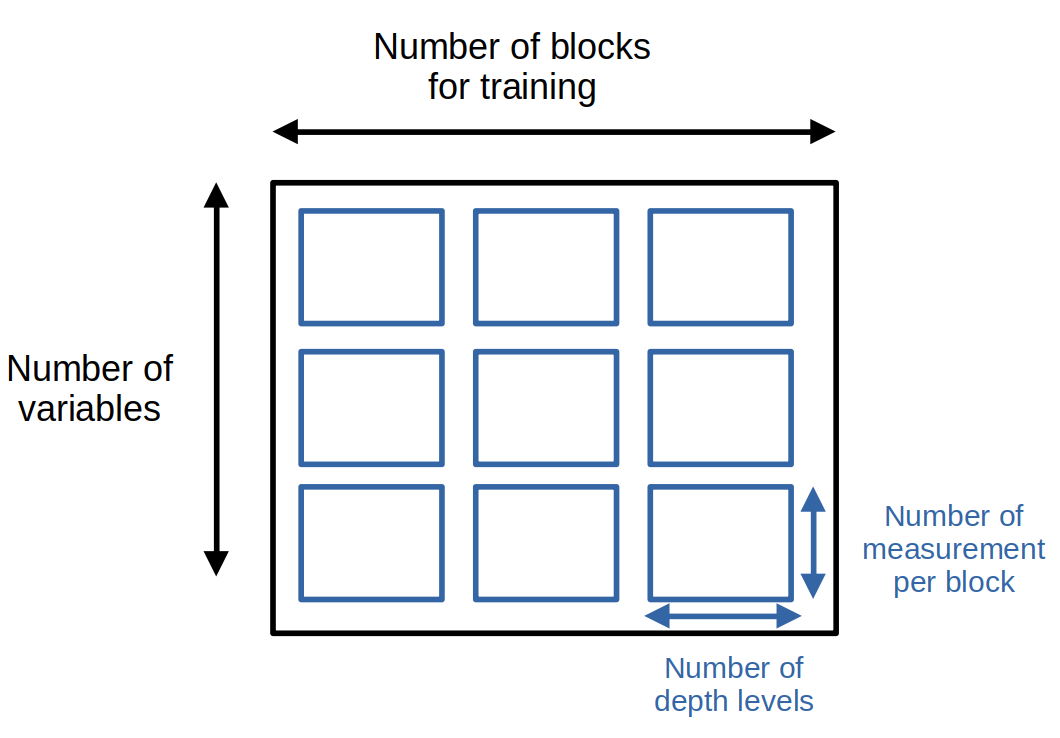

In [4]:
# example for surface data
print(np.shape(surf_data))
print(np.shape(surf_data[0,1]))

(4, 19)
(73, 1)


In [5]:
# example for profile data
print(np.shape(prof_data))
print(np.shape(prof_data[0,1]))

(1, 19)
(73, 58)


In [6]:
# Normalization of the data
surf_train_norm, surf_data_mean, surf_data_stdev,  surf_data_max, surf_data_min = normalization(nb_blocks_train, surf_data, len(surf_var))
prof_train_norm, prof_data_mean, prof_data_stdev,  prof_data_max, prof_data_min = normalization(nb_blocks_train, prof_data, len(prof_var))

In [7]:
# SOM creation
SOM_surf = som.Som(surf_n,surf_m,surf_var,len(surf_var),weights=None,name='som_surface',
                   data_mean=surf_data_mean, data_stdev=surf_data_stdev)

SOM_prof = som.Som(prof_n, prof_m, prof_var,len(depth_levels),weights=None,name='som_profile',
                   data_mean=prof_data_mean, data_stdev=prof_data_stdev)

# Initilization of the SOM weights
if initialization == "Gaussian":        
    SOM_surf.random_weights_initialization(distribution = "gaussian")
    SOM_prof.random_weights_initialization(distribution = "gaussian")
    
elif initialization == "PCA":
    SOM_surf.pca_weights_initialization(np.concatenate(surf_train_norm))
    SOM_prof.pca_weights_initialization(np.concatenate(prof_train_norm))

## 1.2) SOM training
There are some parameters for SOM training that are hardcoded in this function to default values :
- Learning rate
- Radius of neighbourhood function
- Number of epochs for each phase

In [8]:
# Function to apply training for both SOM 
def training(mySom, epochs_list, nb_blocks_train, input_train):
    print("------- Training for '{}' --------".format(mySom.name))
    print("------------------------------------------------")
    lr_initial_list, lr_final_list =  [1,1], [0.2,0.2] #Learning rate, default
    s_initial_list, s_final_list = [6,0.1], [1,0.001] #Radius of the neighbourhood function, default
    
    for training_step in range(len(lr_initial_list)):

        lr_initial = lr_initial_list[training_step]
        lr_final = lr_final_list[training_step]

        s_initial = s_initial_list[training_step]
        s_final = s_final_list[training_step]

        epochs = epochs_list[training_step]

        param = (lr_initial,lr_final,s_initial,s_final)
        T_train = len(np.concatenate(input_train))

        for e in range(epochs):
            print("#### Epoch : ", e, " ####")
            for y in range(nb_blocks_train):
                # Train the SOM with one more year from the training dataset 
                inputs = input_train[y]
                mySom.train(
                    data_train=inputs, 
                    param=param, 
                    T_train=T_train
                )

            # Hyperparameters can be updated after each epoch for a better control over the training
            lr_initial=lr_final
            lr_final=max(lr_final/1.2,0.01) # 0.01 limit value comes from common test on SOM, same for 1.2
            s_initial=s_final
            s_final=max(s_final/1.2,0.5) # 0.5 limit value comes from common test on SOM, same for 1.2
            # ----------------------------
            param = (lr_initial,lr_final,s_initial,s_final)
            
        print("------------------------------------------------")
        print("-------- Phase {} of training finished ---------".format(training_step+1))
        print("------------------------------------------------")

In [9]:
# Training both of the SOM
training(mySom=SOM_surf, epochs_list= [4,4] , nb_blocks_train= nb_blocks_train, input_train= surf_train_norm)
training(mySom=SOM_prof, epochs_list= [6,6] , nb_blocks_train= nb_blocks_train, input_train= prof_train_norm)

------- Training for 'som_surface' --------
------------------------------------------------
#### Epoch :  0  ####
Graph initialization
#### Epoch :  1  ####
Graph initialization
#### Epoch :  2  ####
Graph initialization
#### Epoch :  3  ####
Graph initialization
------------------------------------------------
-------- Phase 1 of training finished ---------
------------------------------------------------
#### Epoch :  0  ####
Graph initialization
#### Epoch :  1  ####
Graph initialization
#### Epoch :  2  ####
Graph initialization
#### Epoch :  3  ####
Graph initialization
------------------------------------------------
-------- Phase 2 of training finished ---------
------------------------------------------------
------- Training for 'som_profile' --------
------------------------------------------------
#### Epoch :  0  ####
Graph initialization
#### Epoch :  1  ####
Graph initialization
#### Epoch :  2  ####
Graph initialization
#### Epoch :  3  ####
Graph initialization
#### E

## 1.3) Visualize referent vectors deployment on data
To analyze how relevant is the SOM, a good way is to check the distribution of referent vectors over the dataset. However, as humans we visualize figures in 2D, that's why we need to do projection :

- As profile data has just one variable, we have chosen to use 2 main PCA axes for 2D projection.

- For surface data, there are several variables, so we can do this in several 2D projection with always the variable linked to chlorphylle-a in ordinate.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


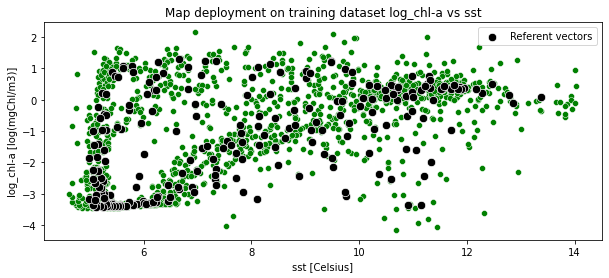

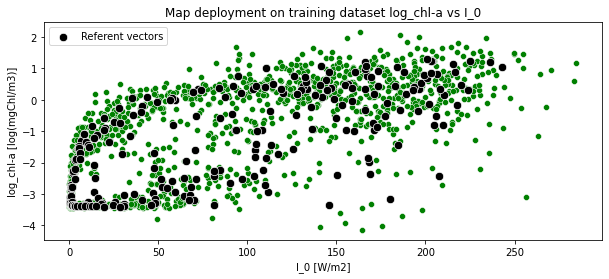

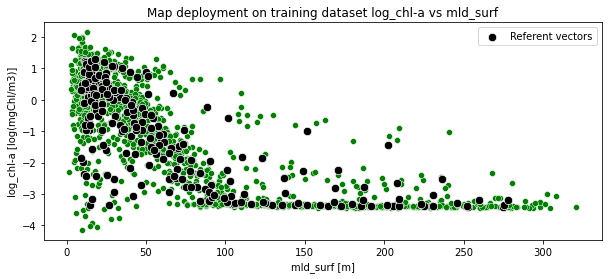

In [10]:
# Creation of a map for surface dataset with its SOM
map_surf = map2d.Map2d(som=SOM_surf,name="surf_train_mapped")
map_surf.map_from_data(np.concatenate(surf_train_norm))

# Visualization with projection on all variables couple
for k in range(1,len(surf_var)):
    plt.figure(figsize=(10,4))
    for i in range(nb_blocks_train):
        sns.scatterplot(x=surf_data[k][i].flatten(), y=surf_data[0][i].flatten(),color='g')
    sns.scatterplot(x=map_surf.som.weights[:,k], y=map_surf.som.weights[:,0],color='k',label = 'Referent vectors', s = 70)
    plt.xlabel(surf_var[k]+" ["+surf_unit[k]+"]")
    plt.ylabel(surf_var[0]+" ["+surf_unit[0]+"]")
    plt.title('Map deployment on training dataset {} vs {}'.format(surf_var[0],surf_var[k]))
    plt.show()

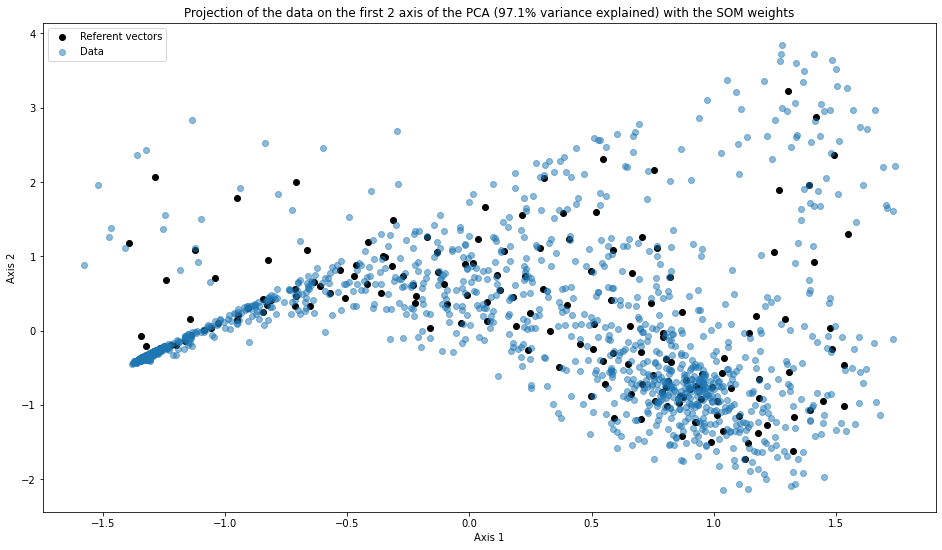

In [11]:
# Creation of a map for profile dataset with its SOM
map_prof = map2d.Map2d(som=SOM_prof,name="prof_train_mapped")
map_prof.map_from_data(np.concatenate(prof_train_norm))

# Projection on 2 main PCA axis
map_prof.som.print_weights_pca_axis(np.concatenate(prof_train_norm), True)
plt.legend(["Referent vectors","Data"])

# 2) Creation of HMM
The method ``init_model`` initializes the probabilities (elements of the matrices ``(Tr, Em, pi)``) by counting the transitions and emission in the training dataset.

``myHMM.pi`` is initialized with a simple uniform probabilities.

In [12]:
# For real data we need extra-steps during HMM training which aren"t relevant for the tutorial, 
# as we use model data.
neighborhood, baum_welch_algo, smooth_transitions = False, False, False

# HMM creation and initialization
myHMM = hmm.Hmm(surf_n*surf_m, prof_n* prof_m, name="hmm_tutorial")
myHMM.init_model(map_surf.classes, map_prof.classes, ln_eps = -50)
myHMM.pi = np.ones((prof_n* prof_m))  

In [13]:
def transm_emi(HMM):
    """ To see transition and emission matrix """
    fig= plt.figure(figsize=(10,10))
    sns.heatmap(HMM.Tr, annot=False)
    plt.title("Transition matrix")
    fig= plt.figure(figsize=(10,10))
    sns.heatmap(HMM.Em, annot=False)
    plt.title("Emission matrix")

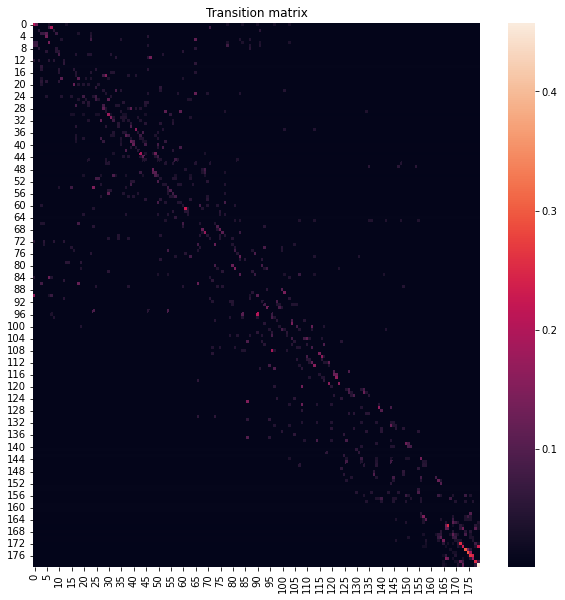

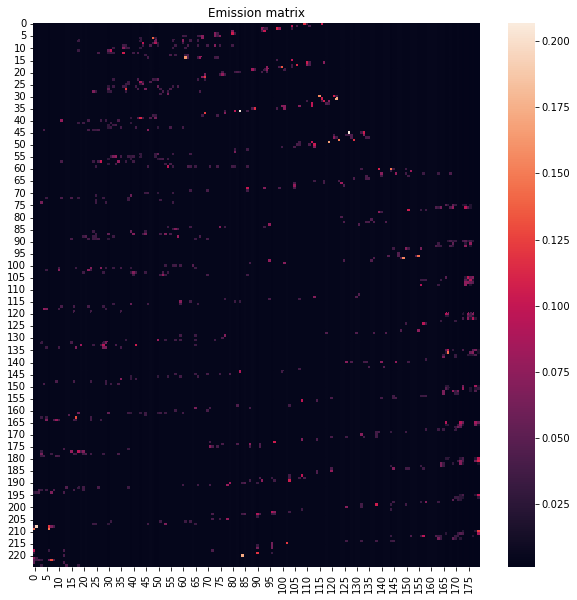

In [14]:
transm_emi(myHMM)

# 3) Save objects
We now save our HMM object to use its properties : Transition and Emission matrix later to infer new data with the Viterbi algorithm. We also need SOM objects, to classify data.

In [15]:
# Save surface SOM
SOM_surf.clear_map_info()
SOM_surf.map(np.concatenate(surf_train_norm))
som.save(SOM_surf, filename = "surf", path="./objects/{}/Som/".format(name_experiment))

# Save profile SOM
SOM_prof.clear_map_info()
SOM_prof.map(np.concatenate(prof_train_norm))
som.save(SOM_prof, filename = "prof", path="./objects/{}/Som/".format(name_experiment))

# Save HMM
hmm.save(myHMM, filename="hmm" ,path="./objects/{}/Hmm/".format(name_experiment))

# 4) (Optionnal) HMM other steps, used for real data



## 4.1) Neighborhood function
In practice, there is not enough training data to
estimate properly the elements of Em and Tr (and
especially Tr) even with a complete set of surface
and subsurface time-series. To overcome this problem, we use a neighbouring
function that exploits the topological properties of the
SOM.

In [16]:
if neighborhood:
    outlier_threshold = 1
    ref_distance_transitions = map_prof.som.distance_transitions
    q = np.quantile(ref_distance_transitions, outlier_threshold)
    ref_distance_transitions = np.where(ref_distance_transitions>q, np.nan, ref_distance_transitions)
    dist_ref_mean = np.nanmean(ref_distance_transitions)

    # Apply the neighborhood function to Tr and Em
    myHMM.neighborhood(sigma=dist_ref_mean, distance_matrix=map_surf.som.distance_matrix)

## 4.2) Baum-Welch algorithm
Given a set of observed data, the Baum–Welch algorithm uses expectation–maximization
(EM) algorithm to find the maximum likelihood estimate of the parameters of a HMM.
A EM algorithm is a method to find maximum likelihood estimates of parameters in a
statistical model. The expectation (E) step gives a function for the expectation of the
log-likelihood evaluated. The maximization (M) step, computes parameters maximiz-
ing the expected log-likelihood found on the E step. These parameter-estimates are
then used to determine the distribution of the latent variables in the next E step

In [17]:
if baum_welch_algo:
    iterations = 30 # Default value : 10
    print(" #################### BAUM-WELCH ##########################")
    for i in range(iterations):
        myHMM.bw(np.concatenate([map_surf.classes]))

## 4.3) Smooth transitions
The fewer
vertical profiles we had compared to surface data during
the initialization the greater the impacts of B-W and
observable time-series are. This might cause some
discontinuity in the vertical profile reconstructed. To
prevent this problem we used another neighbourhood
function that decreases the probability to transit from i
to j if they are far from each other in Mdis . Once again
we used the same radius of in this neighbourhood
function.

In [18]:
if smooth_transitions:
    dist_mean = np.mean(map_hid_est.distance_transitions)
    dist_std = np.std(map_hid_est.distance_transitions)
    if (dist_mean>dist_ref_mean):
        print(" #################### SMOOTH_TRANSITIONS ##########################")
        dist_matrix = map_hid_est.som.distance_matrix
        myHMM.neighborhood(sigma=dist_ref_mean,
                            distance_matrix=map_prof.som.distance_matrix)


## 4.4) Second save

In [19]:
if neighborhood or baum_welch_algo or smooth_transitions:
    name_experiment = "experiment1"

    # Save surface HMM
    SOM_surf.clear_map_info()
    SOM_surf.map(np.concatenate(surf_train_norm))
    som.save(SOM_surf, filename = "surf", path="./objects/{}/Som/".format(name_experiment))

    # Save profile SOM
    SOM_prof.clear_map_info()
    SOM_prof.map(np.concatenate(prof_train_norm))
    som.save(SOM_prof, filename = "prof", path="./objects/{}/Som/".format(name_experiment))

    # Save HMM
    hmm.save(myHMM, filename="hmm" ,path="./objects/{}/Hmm/".format(name_experiment))